In [34]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn 
import random 
import os 
from gensim.models import Word2Vec

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
dpath = 'BlogCatalog-dataset/data/'
edges = pd.read_csv(os.path.join(dpath, 'edges.csv'), header=None)
group_edges = pd.read_csv(os.path.join(dpath, 'group-edges.csv'), header=None)
groups = pd.read_csv(os.path.join(dpath, 'groups.csv'), header=None)
nodes = pd.read_csv(os.path.join(dpath, 'nodes.csv'), header=None) 


In [21]:
edges[0] = edges[0] - 1 
edges[1] = edges[1] - 1 
edges

,0,1
0,0,175
1,0,232
2,0,282
3,0,370
4,0,393
...,...,...
333978,10301,10309
333979,10302,10309
333980,10304,10310
333981,10306,10309


In [29]:
i,j =  edges.loc[0]

In [31]:
edge_list = [[] for _ in range(len(edges))]

for i in range(len(edges)):
    j,k = edges.loc[i]
    edge_list[j].append(k)
    edge_list[k].append(j)

In [42]:
class DeepWalk(nn.Module):
    def __init__(self, edges,num_nodes, embedding_dim=2, window_size=10, walk_length=20, num_walks=6):
        super(DeepWalk, self).__init__()
        self.edges = edges
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.walk_length = walk_length
        self.num_walks = num_walks
        
    def random_walk(self, node):
        walk = [node]
        for _ in range(self.walk_length):
            walk.append(random.choice(self.edges[walk[-1]]))
        return walk
    
    def make_walks(self):
        walk_list = []
        for node in range(self.num_nodes):
            for _ in range(self.num_walks):
                walk_list.append(self.random_walk(node))
        
        return walk_list
    
    def train(self):
        walks = self.make_walks()
        # if sg = 1 : skip-gram
        # if hs = 1 : hierarchical softmax
        model = Word2Vec(walks, vector_size=self.embedding_dim, window=self.window_size, sg=1, hs=1)
        self.embedding = model
        
        return self.embedding
    
    

In [43]:
model = DeepWalk(edge_list, len(nodes))
DeepWalk_Embedding = model.train()

Text(0.5, 1.0, 'Representations of BlogCatalog dataset using DeepWalk')

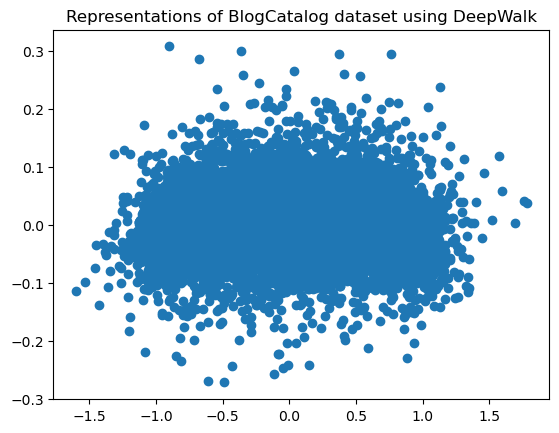

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

x_coords = []
y_coords = []
word_vectors = [DeepWalk_Embedding.wv[v] for v in DeepWalk_Embedding.wv.key_to_index.keys()]
pca = PCA(n_components=2)
# edge_list = DeepWalk_Embedding.wv.vocab
pca_result = pca.fit_transform(word_vectors)
for x,y in pca_result:
    x_coords.append(x)
    y_coords.append(y)
plt.scatter(x_coords, y_coords)
# for i,v in enumerate(edge_list):
#     plt.annotate(v,xy=(x_coords[i],y_coords[i]))
plt.title("Representations of BlogCatalog dataset using DeepWalk")